In [1]:
'''Compare Assessor SQFT to OSM and LARIAC for yearly roll by landbase geoms'''

'Compare Assessor SQFT to OSM and LARIAC for yearly roll by landbase geoms'

In [2]:
import os
os.chdir('../..')

In [3]:
'''creat list of neighborhoods in LA city'''
from src.geoadmin import load_neighborhoods, load_cities

import geopandas as gpd

cities = load_cities().to_crs(4326)
hoods = load_neighborhoods()

assert hoods.crs == cities.crs, "CRS mismatch between neighborhoods and cities data"

lacity = cities.query('CITYNAME_ALF == "LOS ANGELES"')
hoodnames = gpd.sjoin(hoods.set_geometry(hoods.centroid.to_crs(epsg=4326)).set_crs(4326),
                         lacity[['geometry']],
                        #  predicate='within'
                         )['name'].tolist()
print(f'Found {len(hoodnames)} neighborhoods in LA city')

Found 113 neighborhoods in LA city


/var/folders/7b/rl6lkdns1dbfv_n3wwwmq8580000gn/T/ipykernel_74562/3813383796.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hoodnames = gpd.sjoin(hoods.set_geometry(hoods.centroid.to_crs(epsg=4326)).set_crs(4326),


In [4]:
#landbase years available are limited, missing 2014,2019,2020,'''
from src.geoadmin import get_landbase_layer
get_landbase_layer()

{2011: 'Landbase2011',
 2012: 'Landbase2012',
 2013: 'Landbase2013',
 2016: 'Landbase2016',
 2017: 'Landbase2017',
 2018: 'Landbase2018',
 2021: 'Landbase_Dec2021',
 2022: 'Landbase_Dec2022',
 2023: 'Landbase_Dec2023',
 2024: 'Landbase_Dec2024',
 2025: 'LANDBASE_June2025'}

In [ ]:
import numpy as np
import geopandas as gpd

from src.geoadmin import get_landbase_bymask, load_assessor_parcels_bygeom, load_laraic

def load_data_by_year(neighborhood, 
                      lb_yr, apd_yr, lar_yr, source = 'lariac'):
    
    landbase_parcels = get_landbase_bymask(neighborhood, lb_yr)

    polygon_geometry = neighborhood.iloc[0].geometry
    assessor_data = load_assessor_parcels_bygeom(polygon_geometry)
    assessor_data = assessor_data.loc[assessor_data.RollYear == apd_yr]
    assessor_data = assessor_data.to_crs(landbase_parcels.crs)

    if source == 'lariac':
        lariac_structures = load_laraic(neighborhood, lar_yr)
        lariac_structures = lariac_structures.to_crs(landbase_parcels.crs)

    return landbase_parcels, assessor_data, lariac_structures

def sjoin_compare_area(landbase_parcels, assessor_data, 
                 other_data, area_col = 'AREA', other_cols = ['BLD_ID', 'geometry']):
    """join and compare assessor data to other structure data via landbase parcels"""

    lb_cols = ['ASSETID', 'geometry']

    apd_join = gpd.sjoin(
        landbase_parcels[lb_cols],
        assessor_data[['AIN','totBuildingDataLines', 'SQFTmain', 'geometry']],
        how='right'
    )

    apd_agg = apd_join.groupby('ASSETID').agg(
        apd_size=('ASSETID', 'size'),
        apd_n_structures=('totBuildingDataLines', 'sum'),
        apd_gross_area=('SQFTmain', 'sum'),
        apd_max_area=('SQFTmain', 'max'),
    )

    # identify area column in other data, use FIRST match
    area_col = other_data.columns[other_data.columns.str.contains(area_col)][0]
    other_cols = list(dict.fromkeys(other_cols + [area_col]))

    lar_join = gpd.sjoin_nearest(
        landbase_parcels[lb_cols],
        other_data[other_cols],
        how='right'
    )

    lar_agg = lar_join.groupby('ASSETID').agg(
        lar_n_structures=('ASSETID', 'size'),
        lar_gross_area=(area_col, 'sum'),
        lar_max_area=(area_col, 'max'),
        geometry=('geometry', 'first'),
    )

    results = gpd.GeoDataFrame(
        apd_agg.join(lar_agg, how='outer'),
        geometry='geometry',
        crs=landbase_parcels.crs
    )

    return results.reset_index()

def safe_log_ratio(a, b):
    return np.log1p(a / b)

def append_diff_metrics(results):
    """ compute and append log ratio difference metrics for area and structure counts"""
    
    results['diff_gross_area'] = safe_log_ratio(results['apd_gross_area'], results['lar_gross_area'])
    results['diff_max_area'] = safe_log_ratio(results['apd_max_area'], results['lar_max_area'])
    results['diff_n_structures'] = safe_log_ratio(results['apd_n_structures'], results['lar_n_structures'])
    return results


In [13]:
def load_cities():
    """
    Returns a GeoDataFrame containing the cities in the
    Los Angeles area.

    Returns:
    GeoDataFrame: A GeoDataFrame containing the cities in the Los Angeles area.
    crs: EPSG:2229
    """
    cities_url = "https://services.arcgis.com/RmCCgQtiZLDCtblq/arcgis/rest/services/admin_dist_SDE_DIST_DRP_CITY_COMM_BDY/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
    cities = gpd.read_file(cities_url)
    return cities.to_crs(epsg=2229)

cities = load_cities()

In [8]:
"""
process yearly parcel comparisons for each neighborhood (parallel)

Parallelization strategy:
- Each task = (lb_yr, apd_yr, lar_yr, la_neighborhood)
- Run tasks in parallel and concatenate results

"""

from tqdm.auto import tqdm
import pandas as pd
from joblib import Parallel, delayed


landbase_years = [2013, 2017, 2021]  # get_landbase_layer to see what years are available
adp_years      = [2014, 2017, 2020]
lariac_years   = [2014, 2017, 2020]


# --- worker ---
def process_one(neighborhood_name, lb_yr, apd_yr, lar_yr):
    # Filter neighborhood geometry
    neighborhood = hoods.query("name == @neighborhood_name")

    # Load inputs
    landbase_parcels, assessor_data, lariac_structures = load_data_by_year(
        neighborhood, lb_yr, apd_yr, lar_yr, "lariac"
    )

    # Compare / join
    res = sjoin_compare_area(
        landbase_parcels,
        assessor_data,
        lariac_structures,
        area_col="AREA",
        other_cols=["BLD_ID", "geometry"],
    )

    # Post-processing
    res = append_diff_metrics(res)
    res["RollYear"] = apd_yr  # year of assessor data
    res["Neighborhood"] = neighborhood_name
    res["LandbaseYear"] = lb_yr
    res["LariacYear"] = lar_yr
    return res


# --- build task list ---
year_triples = list(zip(landbase_years, adp_years, lariac_years))
neighborhoods = list(hoodnames)  # limit to first 2 for testing (remove [:2] to run all)

tasks = [
    (nh, lb_yr, apd_yr, lar_yr)
    for (lb_yr, apd_yr, lar_yr) in year_triples
    for nh in neighborhoods
]

# --- run in parallel ---
# n_jobs=-1 uses all cores. prefer="processes" is best for CPU-heavy geospatial ops.
# If most time is spent reading/writing data, try prefer="threads".
n_jobs = -1
prefer = "processes"

results_list = Parallel(n_jobs=n_jobs, prefer=prefer)(
    delayed(process_one)(nh, lb_yr, apd_yr, lar_yr)
    for (nh, lb_yr, apd_yr, lar_yr) in tqdm(
        tasks,
        desc="Processing (year, neighborhood) tasks",
        total=len(tasks),
    )
)

results = pd.concat(results_list, axis=0, ignore_index=True)


Processing (year, neighborhood) tasks:   0%|          | 0/339 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/Users/adamswietek/opt/anaconda3/envs/samgeo/lib/python3.13/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L3Zhci9mb2xkZXJzLzdiL3JsNmxrZG5zMWRiZnZfbjN3d3dtcTg1ODAwMDBnbi9UL2pvYmxpYl9tZW1tYXBwaW5nX2ZvbGRlcl83NDU2Ml9kOGM4OTgxNDVlZGM0MDBkYTMyOGM4OWNiMTI4ZWZmYV85YjZiZmZhMGViYzM0NDU2OGZhZjc4MmE2Y2MyZmNjNA=="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/Users/adamswietek/opt/anaconda3/envs/samgeo/lib/python3.13/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"semlock","base64_name" for automatic cleanup: unknown resource type ("L2xva3ktNz

Traceback (most recent call last):
  File "/Users/adamswietek/opt/anaconda3/envs/samgeo/lib/python3.13/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "UNREGISTER","rtype":"semlock","base64_name" for automatic cleanup: unknown resource type ("L2xva3ktNzQ1NjItYW43ZTYxcHM="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/Users/adamswietek/opt/anaconda3/envs/samgeo/lib/python3.13/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "UNREGISTER","rtype":"semlock","base64_name" for automatic cleanup: unknown resource type ("L2xva3ktNzQ1NjItYm5vZmdnc2Q="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/Users/adamsw

In [ ]:
#save 
results.to_parquet('data/04_results/explore_parcel_results.parquet', index=False)

In [ ]:
'''EXPLORE RESULTS'''

In [22]:
import geopandas as gpd

results= gpd.read_file('data/04_results/lacity_apd_building_features.gpkg')

In [27]:
results.columns

Index(['AIN', 'shape.area.sum', 'shape.volume.sum', 'shape.floorarea.sum',
       'shape.area.max', 'shape.volume.max', 'shape.floorarea.max',
       'shape.n_buildings', 'parcels.area', 'parcels.far',
       'parcels.n_buildings', 'parcels.SQFTmain', 'parcels.unitcount',
       'parcels.bathcount', 'parcels.bdrmcount', 'sp.bar', 'sp.far',
       'sp.resid.floorarea', 'sp.resid.area', 'sp.ratio.floorarea', 'ZIPcode',
       'TaxRateArea_CITY', 'RollYear', 'TaxRateArea', 'AssessorID',
       'PropertyLocation', 'PropertyType', 'PropertyUseCode', 'GeneralUseType',
       'SpecificUseType', 'SpecificUseDetail1', 'SpecificUseDetail2',
       'totBuildingDataLines', 'YearBuilt', 'EffectiveYearBuilt', 'SQFTmain',
       'Bedrooms', 'Bathrooms', 'Units', 'RecordingDate', 'LandValue',
       'LandBaseYear', 'ImprovementValue', 'ImpBaseYear', 'TotalLandImpValue',
       'HomeownersExemption', 'RealEstateExemption', 'FixtureValue',
       'FixtureExemption', 'PersonalPropertyValue',
       'Pers

In [46]:
def plot_diff_ecdf(varA, varB):
    lar_diff = (results
    .groupby(['AIN', 'RollYear'])[varA]
    .mean()
    .unstack()
    .fillna(0)).diff(axis=1)

    apd_diff = (results
    .groupby(['AIN', 'RollYear'])[varB]
    .mean()
    .unstack()
    .fillna(0)).diff(axis=1)

    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd

    df_plot = pd.DataFrame({
        "change": pd.concat([lar_diff[2017], apd_diff[2017], lar_diff[2020], apd_diff[2020]]),
        "dataset": (["LAR"] * len(lar_diff[2017])
                    + ["APD"] * len(apd_diff[2017])
                    + ["LAR"] * len(lar_diff[2020])
                    + ["APD"] * len(apd_diff[2020])),
        "period": (["2014–2017"] * len(lar_diff[2017])
                + ["2014–2017"] * len(apd_diff[2017])
                + ["2017–2020"] * len(lar_diff[2020])
                + ["2017–2020"] * len(apd_diff[2020]))
    }).dropna()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    sns.ecdfplot(data=df_plot[df_plot["period"]=="2014–2017"], x="change", hue="dataset", ax=axes[0])
    axes[0].set_title("2014 → 2017")
    axes[0].set_xlabel("Δ gross area")

    sns.ecdfplot(data=df_plot[df_plot["period"]=="2017–2020"], x="change", hue="dataset", ax=axes[1])
    axes[1].set_title("2017 → 2020")
    axes[1].set_xlabel("Δ gross area")

    axes[0].set_xscale('symlog', linthresh=1)
    axes[1].set_xscale('symlog', linthresh=1)

    plt.tight_layout()
    plt.show()

def plot_diff_hist(var_a, var_b):
    import matplotlib.pyplot as plt

    lar_diff = (results
    .groupby(['AIN', 'RollYear'])[var_a]
    .mean()
    .unstack()
    .fillna(0)).diff(axis=1)

    apd_diff = (results
    .groupby(['AIN', 'RollYear'])[var_b]
    .mean()
    .unstack()
    .fillna(0)).diff(axis=1)

    # value counts for each change year
    lar_2017 = lar_diff[2017].value_counts().sort_index()
    lar_2020 = lar_diff[2020].value_counts().sort_index()
    apd_2017 = apd_diff[2017].value_counts().sort_index()
    apd_2020 = apd_diff[2020].value_counts().sort_index()

    # align indices so bars line up
    idx_2017 = sorted(set(lar_2017.index).union(apd_2017.index))
    idx_2020 = sorted(set(lar_2020.index).union(apd_2020.index))

    fig, axes = plt.subplots(1,2 , figsize=(12, 4), sharey=True)

    axes[0].bar([i - 0.2 for i in range(len(idx_2017))],
                [lar_2017.get(x, 0) for x in idx_2017],
                width=0.4, label='LAR')
    axes[0].bar([i + 0.2 for i in range(len(idx_2017))],
                [apd_2017.get(x, 0) for x in idx_2017],
                width=0.4, label='APD')
    axes[0].set_title('2014 → 2017 change counts')
    axes[0].set_xticks(range(len(idx_2017)))
    axes[0].set_xticklabels(idx_2017, rotation=45)

    axes[1].bar([i - 0.2 for i in range(len(idx_2020))],
                [lar_2020.get(x, 0) for x in idx_2020],
                width=0.4, label='LAR')
    axes[1].bar([i + 0.2 for i in range(len(idx_2020))],
                [apd_2020.get(x, 0) for x in idx_2020],
                width=0.4, label='APD')
    axes[1].set_title('2017 → 2020 change counts')
    axes[1].set_xticks(range(len(idx_2020)))
    axes[1].set_xticklabels(idx_2020, rotation=45)
    axes[0].set_yscale('log'), axes[1].set_yscale('log')
    axes[0].set_ylabel('count of parcels')
    axes[0].legend()
    plt.tight_layout()
    plt.show()


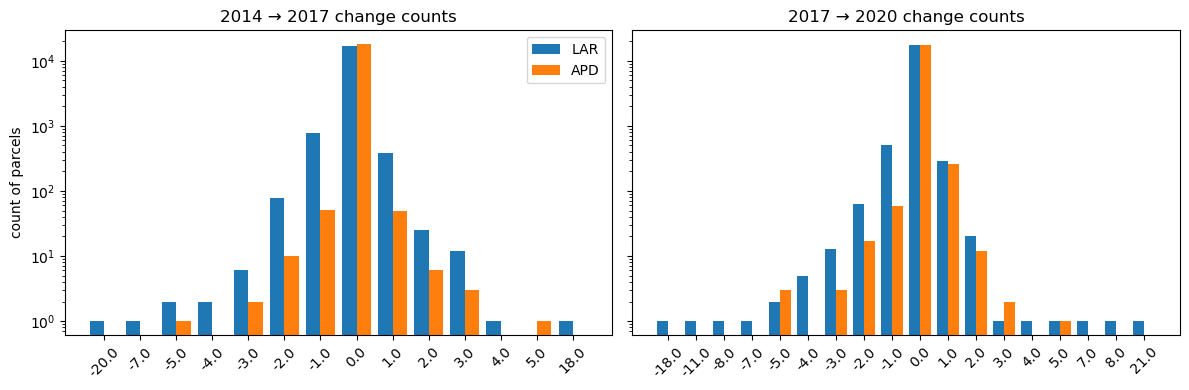

In [47]:
plot_diff_hist('shape.n_buildings', 'totBuildingDataLines')

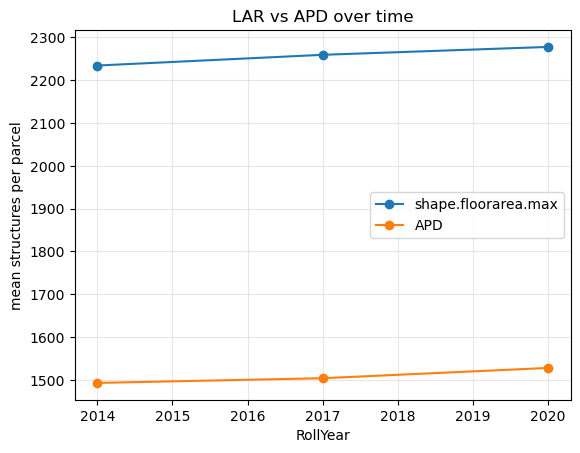

In [63]:
import matplotlib.pyplot as plt

mean_over_time = (results
    .groupby("RollYear")[["shape.floorarea.max", "SQFTmain"]]
    .median()
    .rename(columns={
        "shape.floorarea.sum": "LAR",
        "SQFTmain": "APD"
    })
)

mean_over_time.plot(marker="o")
plt.ylabel("mean structures per parcel")
plt.title("LAR vs APD over time")
plt.grid(alpha=0.3)
plt.show()


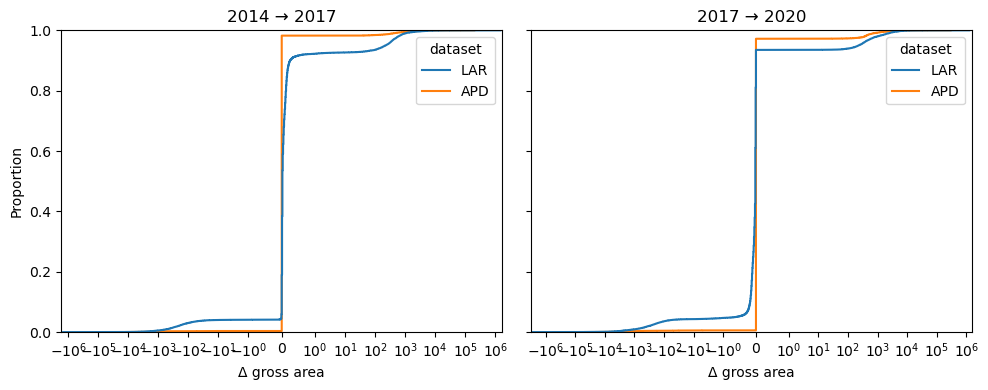

In [45]:
plot_diff_ecdf('shape.floorarea.sum', 'parcels.SQFTmain')

(None, None)

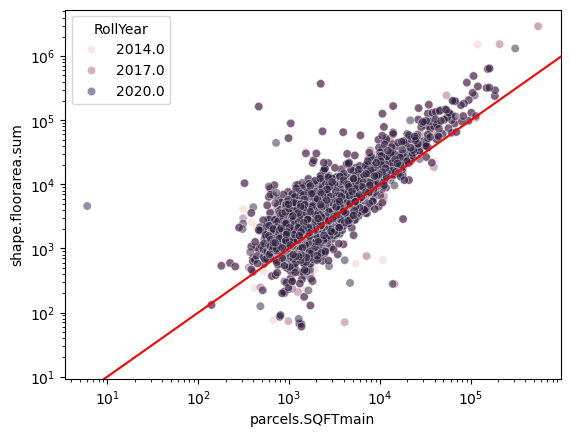

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.scatterplot(data=results.reset_index(),
            #  x = 'apd_n_structures',y = 'lar_n_structures', 
            #  x = 'apd_gross_area',y = 'lar_gross_area', 
             x = 'parcels.SQFTmain',y = 'shape.floorarea.sum', 
             alpha = .5,
            #  scatter_kws={'s':1},
             hue = 'RollYear')

ax.axline((0, 0), slope=1., color='r', label='by slope')

plt.xscale('log'), plt.yscale('log')

Text(0.5, 0.98, 'LARIAC vs APD building size and counts mapped to landbase parcels')

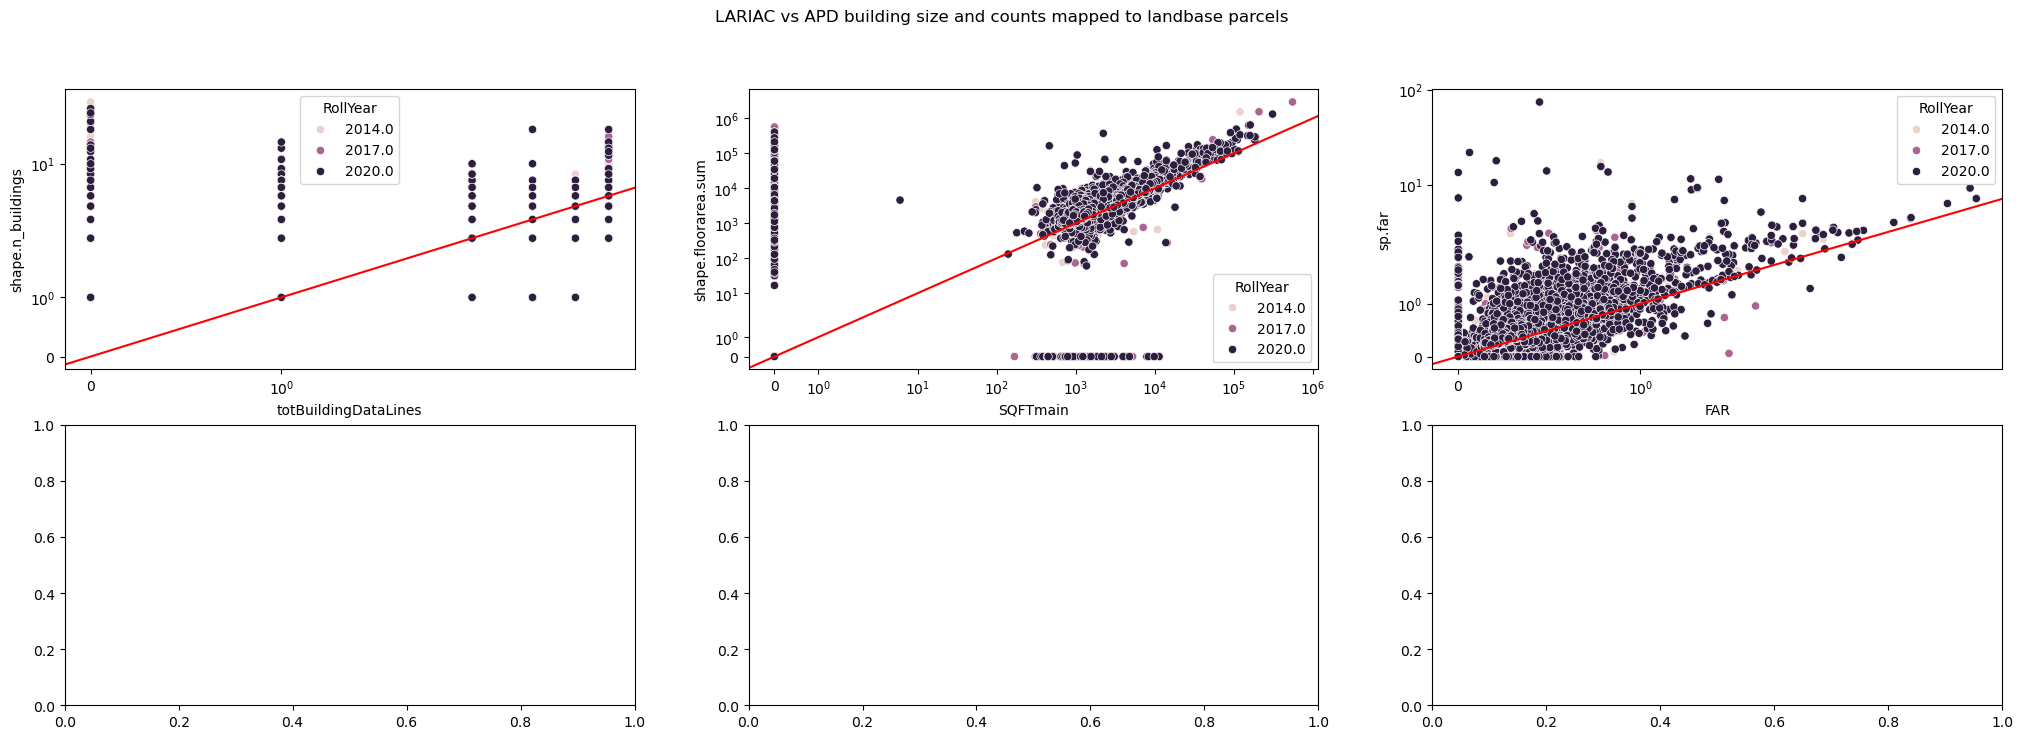

In [51]:
import seaborn as sns
x_vars = ['totBuildingDataLines', 'SQFTmain', 'FAR']
y_vars = ['shape.n_buildings', 'shape.floorarea.sum', 'sp.far']

d = results.reset_index()

f, ax = plt.subplots(1,3, figsize = (25,8))
ax = ax.flatten()
for ax, x,y in zip(ax, x_vars, y_vars):
    sns.scatterplot(
        data = d,
        x = x,
        y = y,
        hue = 'RollYear',
        ax = ax, #size=1, alpha=0.5
    )
    ax.axline((0, 0), slope=1., color='r', label='by slope')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

plt.suptitle('LARIAC vs APD building size and counts mapped to landbase parcels')

<Axes: >

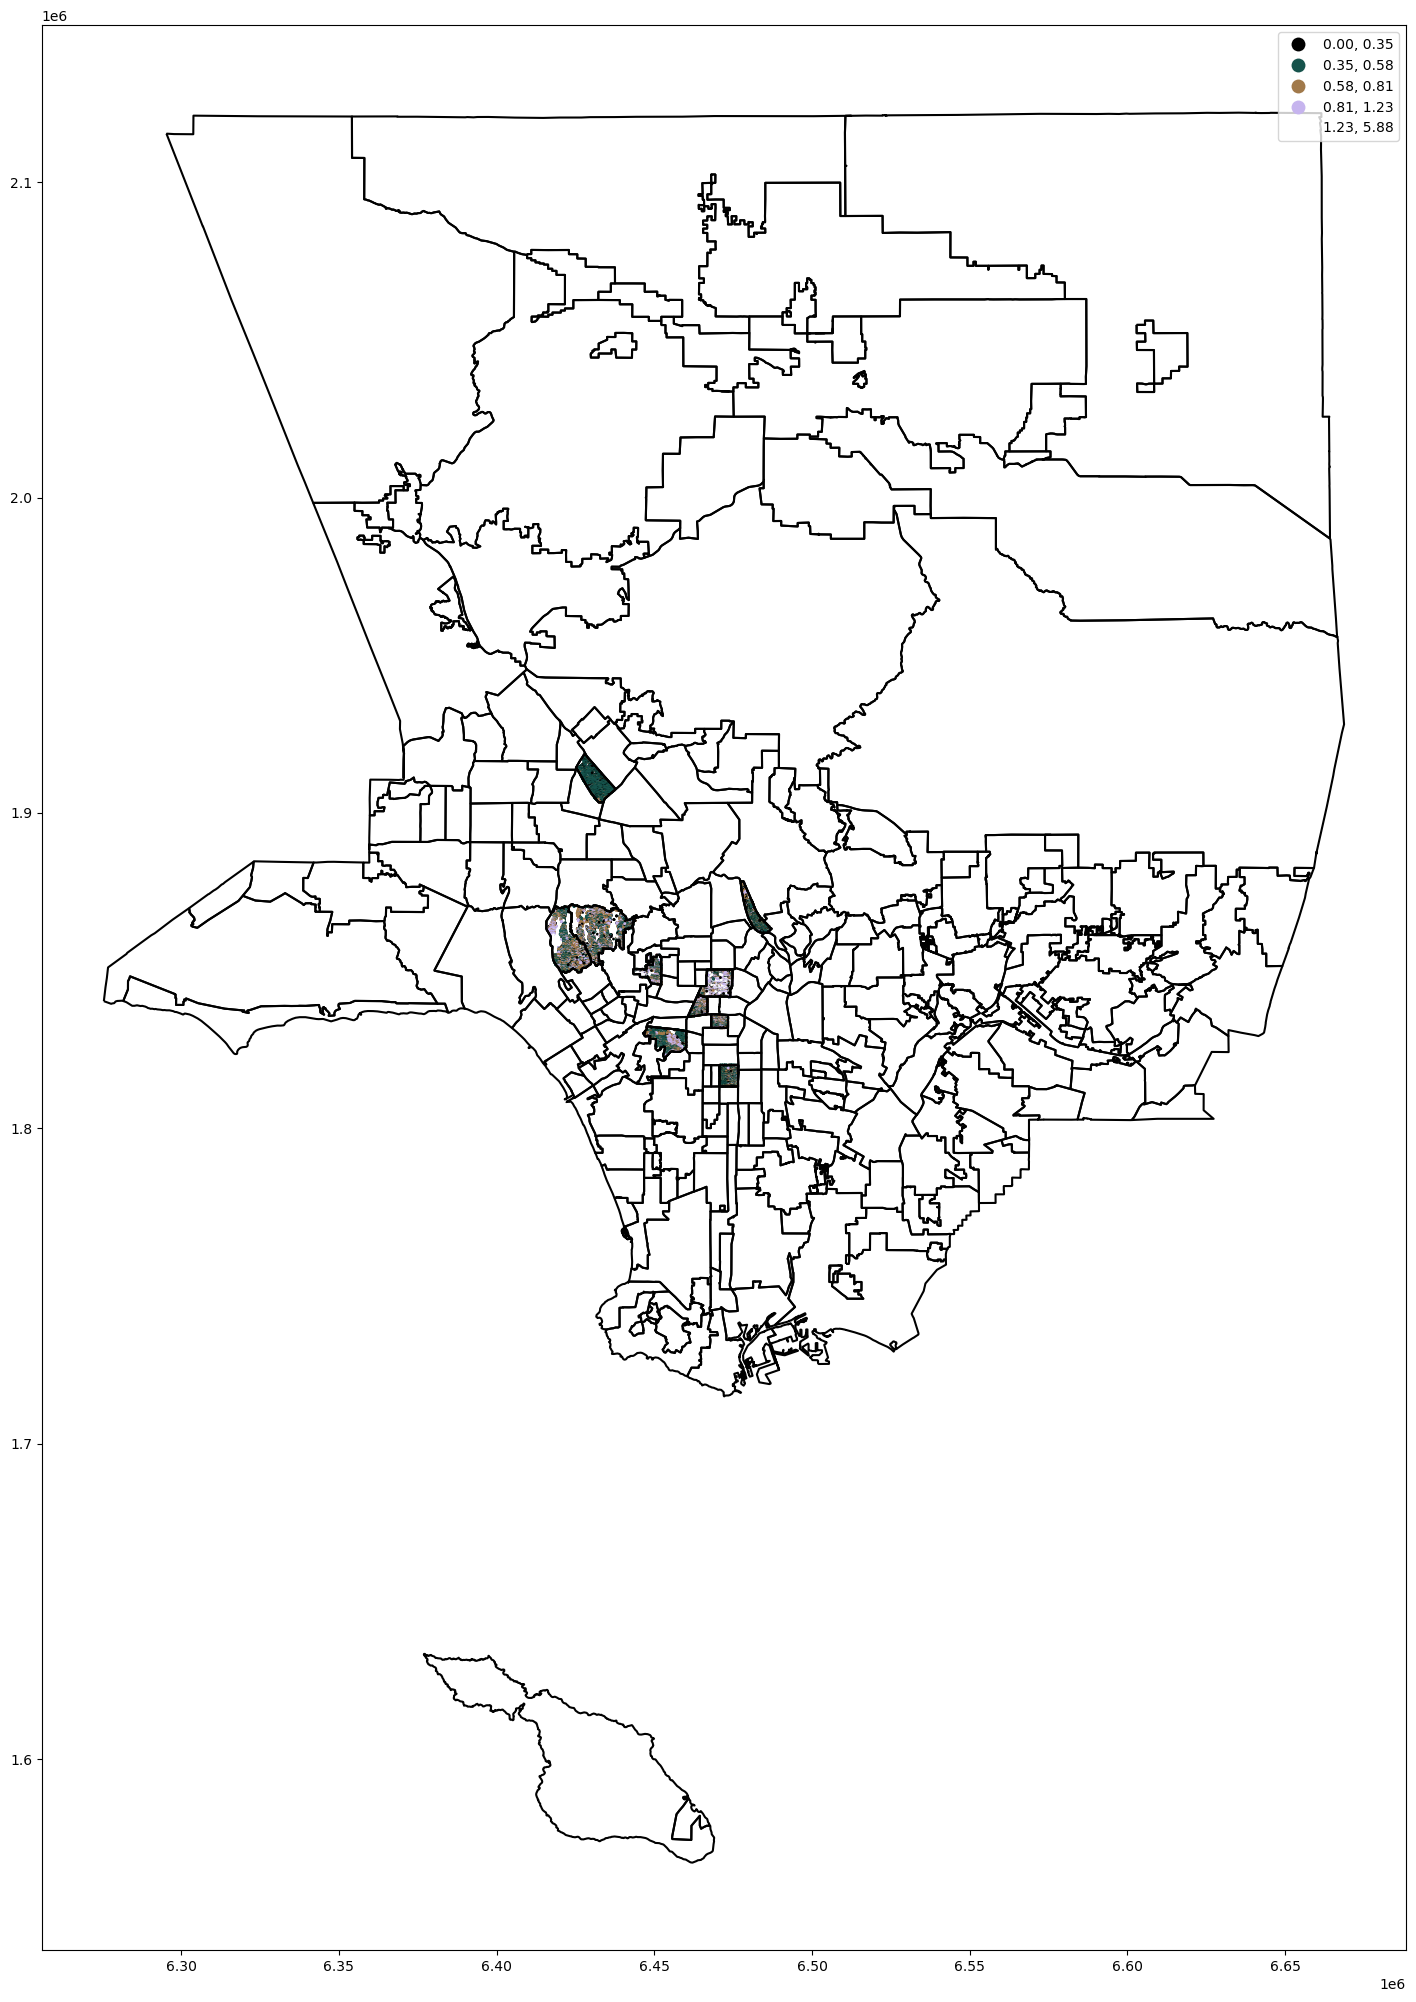

In [44]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize = (25,25))

hoods.to_crs(landbase_parcels.crs).boundary.plot(color = 'k', ax = ax)
hoods[hoods.name.isin(hoods_names)].to_crs(landbase_parcels.crs).boundary.plot(color = 'k', ax = ax)
# landbase_parcels.plot(alpha = .5, ax = ax)
# lariac_structures.plot(ax = ax, color = 'k')
# assessor_data.plot(ax = ax, color = 'r')

results.set_geometry(results.centroid).plot('diff_gross_area', 
                                            legend =True, 
                                            scheme= 'naturalbreaks', 
                                            markersize= 1,
                                            cmap = 'cubehelix',
                                            ax = ax)

In [325]:
all_results.columns

Index(['apd_size', 'apd_n_structures', 'apd_gross_area', 'apd_max_area',
       'lar_n_structures', 'lar_gross_area', 'lar_max_area', 'geometry',
       'diff_gross_area', 'diff_max_area', 'diff_n_structures', 'RollYear'],
      dtype='object')

In [54]:
yearly_metrics = results.drop(columns=['geometry']).groupby(['Neighborhood','RollYear']).sum()

In [55]:
yearly_metrics.round(2).T#['apd_size']

Neighborhood      Adams-Normandie                                 Arleta  \
RollYear                     2014         2017         2020         2014   
apd_size                  2057.00      2055.00      2053.00      7020.00   
apd_n_structures          2333.00      2336.00      2348.00      6960.00   
apd_gross_area         6257348.00   6285510.00   6388858.00  10699948.00   
apd_max_area           6193130.00   6221292.00   6323444.00  10458307.00   
lar_n_structures          6208.00      4441.00      4854.00     16435.00   
lar_gross_area        12852883.00  10033353.36  10728878.96  24608203.00   
lar_max_area           9049427.00   8362362.48   8530957.00  16861324.00   
diff_gross_area           1016.91      1255.76      1200.62      2570.71   
diff_max_area             1394.04      1458.74      1452.10      3272.69   
diff_n_structures          789.29      1002.73       947.83      2786.69   
LandbaseYear           5203605.00   5127214.00   5149508.00  14086974.00   
LariacYear             5206190.00   5127214.00   5146960.00  14093972.00   

Neighborhood                                Arlington Heights               \
RollYear                  2017         2020              2014         2017   
apd_size               7020.00      7017.00           2343.00      2337.00   
apd_n_structures       6962.00      7085.00           2737.00      2732.00   
apd_gross_area     10745068.00  10856930.00        9340432.00   9378328.00   
apd_max_area       10503427.00  10611502.00        9294794.00   9332690.00   
lar_n_structures      13012.00     13447.00           7708.00      5554.00   
lar_gross_area     19963929.75  20525109.21       17639307.00  14293083.67   
lar_max_area       16451712.77  16553321.82       12414443.00  11711088.90   
diff_gross_area        2960.30      2928.77           1281.88      1533.23   
diff_max_area          3346.94      3357.91           1776.81      1832.56   
diff_n_structures      3325.88      3295.12            873.80      1099.79   
LandbaseYear       14064541.00  14096475.00        5815557.00   5762569.00   
LariacYear         14064541.00  14089500.00        5818446.00   5762569.00   

Neighborhood                   Atwater Village  ... Beverly Crest  \
RollYear                  2020            2014  ...          2020   
apd_size               2333.00         3588.00  ...       6833.00   
apd_n_structures       2744.00         4323.00  ...       4754.00   
apd_gross_area      9395717.00      9900600.00  ...   17390623.00   
apd_max_area        9348461.00      9759453.00  ...   15796294.00   
lar_n_structures       6202.00        12105.00  ...       8371.00   
lar_gross_area     15257359.67     30273601.00  ...   23621406.44   
lar_max_area       11808334.06     22577108.00  ...   20645832.29   
diff_gross_area        1443.52         1328.22  ...       2707.67   
diff_max_area          1821.23         2043.56  ...       2807.03   
diff_n_structures      1021.83         1274.07  ...       2500.33   
LandbaseYear        5763892.00      8514990.00  ...   15895165.00   
LariacYear          5761040.00      8519220.00  ...   15887300.00   

Neighborhood      Beverly Grove                              Koreatown  \
RollYear                   2014         2017         2020         2014   
apd_size                5846.00      5860.00      5923.00      7759.00   
apd_n_structures        6005.00      5995.00      6057.00      7969.00   
apd_gross_area      26117575.00  26428068.00  27169734.00  57868803.00   
apd_max_area        24209649.00  24493840.00  25026679.00  54473589.00   
lar_n_structures       12301.00      9172.00      9478.00     14489.00   
lar_gross_area      37529456.00  32192030.34  32729624.01  84453550.00   
lar_max_area        29072657.00  27478178.11  27903409.66  70019804.00   
diff_gross_area         2472.47      2884.30      2865.10      3296.94   
diff_max_area           3150.82      3228.44      3232.04      3883.81   
diff_n_structures       1729.40      2089.66      2049.91    